In [1]:
import math
import torch
import gpytorch
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE
from FSGPLVM import FSGPLVM as LVM

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

In [2]:
import sklearn.metrics as sk

In [3]:
mode_weights = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/modes_weights.csv',index_col=0,delim_whitespace=False,header=0)

mode_weights

#mode_weights=mode_weights.drop(15,axis=0)
#mode_weights=mode_weights.drop(14,axis=0)

meshes=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','16','17','18','19']

x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)
x_labels=x_labels.values.flatten().tolist()+mode_weights.columns.tolist()

y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)


same_input=[]
same_output=[]

dif_input = []
dif_output=[]
dif_modes=[]

all_input_dif = []
all_output_dif=[]
all_x_dif=[]
for i in range(len(meshes)):
    val=meshes[i]
    
    same_in = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    same_out = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/same_X/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    dif_in = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/X_EP.txt",index_col=None,delim_whitespace=True,header=None).values
    dif_out = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values
    
    modeweights = np.tile(mode_weights.iloc[i,:].values, (dif_in.shape[0],1))
    input_modes = np.concatenate((dif_in,modeweights),axis=1)
    same_input.append(torch.tensor(same_in))
    same_output.append(torch.tensor(same_out))
    dif_input.append(torch.tensor(dif_in))
    dif_output.append(torch.tensor(dif_out))
    dif_modes.append(torch.tensor(input_modes))

#all_input=pd.concat(all_input)
#all_output=pd.concat(all_output
#all_input.columns=x_labels
#all_output.columns=y_labels

In [4]:
train_input=[]
test_input = []
train_output=[]
test_output = []

train_input_modes=[]
test_input_modes = []
train_output_modes=[]
test_output_modes = []

for i in range(len(meshes)):

    X=dif_input[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    
    X=dif_modes[i]
    y=dif_output[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_modes.append(X_train)
    test_input_modes.append(X_test)
    train_output_modes.append(y_train)
    test_output_modes.append(y_test)


### Fully supervised GPLVM (we should come up with a better acronym/name)

Observations:
$$Y = [y_1,...,y_N], \ y_n \in R^{p}$$
Model parameters
$$X = [x_1,...,x_N], \ x_n \in R^{p\times q}$$
Latent parameters/features
$$L = [l_1,...,l_N], \ l_n \in R^{d }$$
With $d<q$ and $L\sim N(0,I)$.

We want to find a function $f_\theta$ such that:
$$ Y = f_\theta(X,L)+\epsilon $$
Let's make $f$ a GP, as we like to, with mean $m_\theta(X,L)$ and covariance $K_\theta((X,L),(X',L'))$
We would like to learn $L$ and $\theta$ (the hyper-parameters). 

As a cost function we use the likelihood
$$p(Y,L|X) = p(Y|L,X)p(L) $$
and as $f$ is a GP,
$$p(Y|L,X) \sim N(m_\theta(X,L), K_\theta((X,L),(X,L)))$$

Taking the log we have
$$\log p(Y,L|X) = \log p(Y|L,X)+\log p(L) $$
$$ = -\frac{NP}{2}\log(2\pi)-\frac{1}{2}\log|K_\theta|-\frac{1}{2}(Y-m_\theta(X,L))^\top\ K_\theta^{-1}(Y-m_\theta(X,L))-\frac{N}{2}\log(2\pi)-\frac{1}{2}\log|I|-\frac{1}{2}(L)^\top I^{-1}(L)) $$


to calculate $\log |K|$ we use the fact that $\log |K| = 2\Sigma (\log\mathrm{diag}(L)_i)$, where $L$ is the cholesky decomposition of $K$.

In [5]:
def linear_mean(beta,X):
    b_0 = beta[0]
    b = beta[1:end]
    mean = b_0 + b*X

In [6]:
N = 18 #number of systems
p = 40 #observations per system
L_size = 2

In [7]:
c=np.random.choice(range(144),p,replace=False).tolist()
A_TAT_all = train_output[0][c,[0]][:,None]
A_TAT_in = train_input[0][c,:]
for i in range(len(same_output)-1):
    A_TAT_all=torch.cat((A_TAT_all,train_output[i+1][c,[0]][:,None]),axis=0)
    A_TAT_in=torch.cat((A_TAT_in,train_input[i+1][c,:]),axis=0)


V_TAT_all = train_output[0][c,[1]][:,None]

for i in range(len(train_output)-1):
    V_TAT_all=torch.cat((V_TAT_all,train_output[i+1][c,[1]][:,None]),axis=0
                       )

In [8]:
c=np.random.choice(range(144),p,replace=False).tolist()
A_TAT_test = test_output[0][:,0][:,None]
A_TAT_in_test = test_input[0]
for i in range(len(same_output)-1):
    A_TAT_test=torch.cat((A_TAT_test,test_output[i+1][:,0][:,None]),axis=0)
    A_TAT_in_test=torch.cat((A_TAT_in_test,test_input[i+1][:,:]),axis=0)


V_TAT_test = test_output[0][:,1][:,None]

for i in range(len(same_output)-1):
    V_TAT_test=torch.cat((V_TAT_test,test_output[i+1][:,1][:,None]),axis=0
                       )

In [9]:
y_test=torch.cat([A_TAT_test,V_TAT_test],axis=1)
X_test = A_TAT_in_test

In [10]:
y=torch.cat([A_TAT_all,V_TAT_all],axis=1)
X = A_TAT_in

In [11]:
y.shape

torch.Size([720, 2])

In [12]:
y_test.shape

torch.Size([648, 2])

In [13]:
X.shape

torch.Size([720, 6])

In [14]:
Y=y

In [15]:
X=X

In [16]:
X.shape

torch.Size([720, 6])

In [17]:
Y.shape

torch.Size([720, 2])

In [18]:
Y_mean = Y.mean()
Y_std = Y.std()

X_mean = X.mean()
X_std =X.std()

In [19]:
L = torch.rand(p,L_size).clone().detach().requires_grad_(True)

In [20]:
L =torch.normal(0,torch.ones(N,L_size)).clone().detach().requires_grad_(True)
#L =L_true.clone().detach().requires_grad_(True)
scaling = torch.rand(1).clone().detach().requires_grad_(True)
lengthscale = torch.rand(X.shape[1]+L_size).clone().detach().requires_grad_(True)
sigma2 = torch.tensor([0.01]).clone().detach().requires_grad_(True)
mean = torch.rand(1).clone().detach().requires_grad_(True)

In [21]:
XL_train = torch.cat((X,torch.repeat_interleave(L,p,dim=0)),axis=1)

In [22]:
XL_train.shape

torch.Size([720, 8])

In [23]:
LVemulator = LVM.LVE(XL_train,y,0.0001,p,N,6,training_iter=100000,lr=1e-3)

tensor(4204.3135, grad_fn=<NegBackward0>) tensor([[0.0499, 0.6059, 0.4663, 0.7850, 0.2978, 0.6917],
        [0.2871, 0.1991, 0.7324, 0.8716, 0.2282, 0.3770]], requires_grad=True)
tensor(2113.7693, grad_fn=<NegBackward0>) tensor([[0.8423, 1.6074, 1.4144, 1.2128, 1.2441, 1.6973],
        [0.9868, 0.9493, 1.5272, 1.7735, 1.0110, 1.2199]], requires_grad=True)
tensor(1063.1685, grad_fn=<NegBackward0>) tensor([[1.5344, 2.5502, 2.3849, 1.1418, 2.0862, 2.3674],
        [1.5504, 1.5985, 1.6789, 2.7108, 1.7875, 2.0111]], requires_grad=True)
tensor(849.5123, grad_fn=<NegBackward0>) tensor([[1.9286, 3.0830, 2.8988, 0.9225, 2.5898, 2.1033],
        [1.7374, 1.9407, 1.4293, 3.3299, 2.3333, 2.5558]], requires_grad=True)
tensor(760.0114, grad_fn=<NegBackward0>) tensor([[2.2978, 3.5489, 3.2108, 0.8725, 3.0415, 1.7180],
        [1.8094, 2.0981, 1.3520, 3.8031, 2.7221, 2.9752]], requires_grad=True)
tensor(703.2937, grad_fn=<NegBackward0>) tensor([[2.7076, 3.9880, 3.5390, 0.9935, 3.4619, 1.1285],
        

In [24]:
LVemulator.optimise(100000,lr=1e-4)

tensor(575.2260, grad_fn=<NegBackward0>)
tensor(575.5316, grad_fn=<NegBackward0>)
tensor(575.4363, grad_fn=<NegBackward0>)
tensor(574.7618, grad_fn=<NegBackward0>)
tensor(575.4049, grad_fn=<NegBackward0>)
tensor(575.0430, grad_fn=<NegBackward0>)
tensor(575.7368, grad_fn=<NegBackward0>)
tensor(574.5511, grad_fn=<NegBackward0>)
tensor(575.1968, grad_fn=<NegBackward0>)
tensor(575.2346, grad_fn=<NegBackward0>)
tensor(575.7642, grad_fn=<NegBackward0>)
tensor(574.4977, grad_fn=<NegBackward0>)
tensor(575.3196, grad_fn=<NegBackward0>)
tensor(575.3531, grad_fn=<NegBackward0>)
tensor(574.7856, grad_fn=<NegBackward0>)
tensor(574.6909, grad_fn=<NegBackward0>)
tensor(574.5582, grad_fn=<NegBackward0>)
tensor(575.2258, grad_fn=<NegBackward0>)
tensor(574.9087, grad_fn=<NegBackward0>)
tensor(574.4176, grad_fn=<NegBackward0>)
tensor(575.2403, grad_fn=<NegBackward0>)
tensor(575.7535, grad_fn=<NegBackward0>)
tensor(574.9421, grad_fn=<NegBackward0>)
tensor(575.4314, grad_fn=<NegBackward0>)
tensor(575.5766,

In [25]:
XL_test = torch.cat((X_test,torch.repeat_interleave(LVemulator.L,36,dim=0)),axis=1)

In [26]:
LVemulator.R2(XL_test.float(),y_test.float())

tensor([0.9893, 0.9814], grad_fn=<RsubBackward1>)

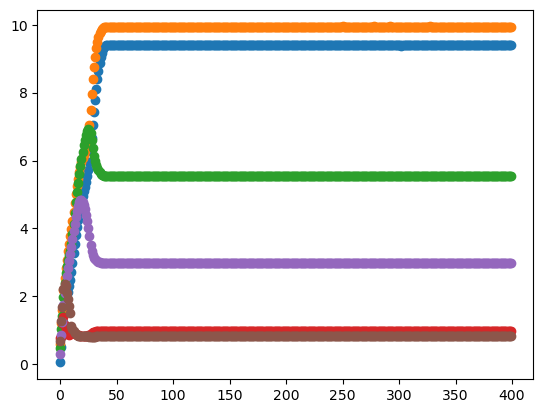

In [27]:
plt.plot(torch.cat(LVemulator.lengths)[::1000],'o')

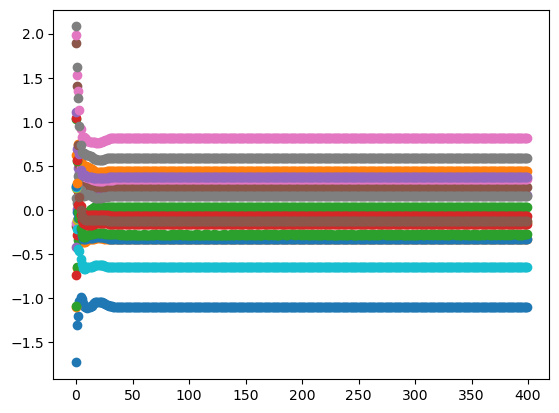

In [28]:
plt.plot(torch.cat(LVemulator.Ls,axis=1).T[::1000],'o')

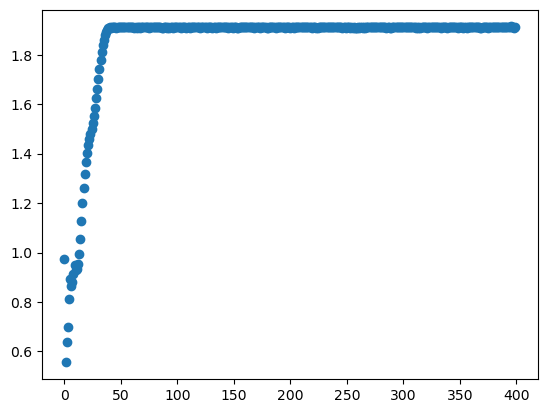

In [29]:
plt.plot(torch.cat(LVemulator.scales)[::1000],'o')

In [30]:
cost(Y,X,L,scaling,lengthscale,sigma2,p)

NameError: name 'cost' is not defined

In [ ]:
#plt.imshow(rbf(X,L,X,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
plt.imshow(rbf2(X,L,X,L,scaling,lengthscale,p,p).detach().numpy())

In [ ]:
for i in range(N):
    plt.plot(X[i*p:(i+1)*p,0],Y[i*p:(i+1)*p],'o')

In [ ]:
cost(Y,X,L,scaling,lengthscale,sigma2,p)

In [ ]:
gd = torch.optim.SGD([L,scaling,lengthscale,mean], lr=1e-5)
history_gd = []

for i in range(500000):
    gd.zero_grad()
    objective = cost(Y,X,L,scaling,lengthscale,sigma2,p,mean)
    objective.backward()
    gd.step()
    history_gd.append(objective.item())
    if i%1000 ==0:
        print(objective)
    if (i>1) and (np.abs(history_gd[-1] - history_gd[-2]) < .000001):
        print("Convergence achieved in ", i+1, " iterations")
        print("-LogL Value: ", objective.item())
        break


In [ ]:
mean

In [ ]:
L

In [ ]:
lengthscale


In [ ]:
cost(Y,X,L_true,scaling,lengthscale,sigma2,p,mean)

In [ ]:
cost(Y,X,L,scaling,lengthscale,sigma2,p,mean)

In [ ]:
mean

Posterior mean: $$m(X^*,X)+K((X^*,L^*),(X,L))^\top(K((X,L),(X,L))+\sigma^2I)^{-1}(Y-m(X,X))$$

In [ ]:
ref=0
l_ref = 0
dif = 0.01

In [ ]:
K=rbf2(X,L,X,L,scaling,lengthscale,p,p)+sigma2*torch.eye(X.shape[0])

In [ ]:
L[l_ref]

In [ ]:
X[0:10]

In [ ]:
test_input[i][:,3:6].shape

In [ ]:
real

In [ ]:
((pred-real[:,None])**2).mean()

In [ ]:
R2=0
for i in range(L.shape[0]):
    K_s = rbf2(X,L,test_input[i][:,:],L[[i]],scaling,lengthscale,p,test_input[i].shape[0])
    pred=mean*Y_std +torch.matmul(K_s.T,torch.linalg.solve(K,Y-mean))*Y_std + Y_mean
    real=test_output[i][:,0]

    R2 += 1-((pred-real[:,None])**2).mean()/(real.std()**2)
    print(1-((pred-real[:,None])**2).mean()/(real.std()**2))
R2=R2/L.shape[0]

print(R2)

In [ ]:
def posterior_theta(X_test,L_test,p_test,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean):
    K = rbf2(X_train,L_train,X_train,L_train,scaling,lengthscale,p_train,p_train)+sigma2*torch.eye(X_train.shape[0])
    K_s = rbf2(X_train,L_train,X_test,L_test,scaling,lengthscale,p_train,p_test)
    K_ss = rbf2(X_test,L_test,X_test,L_test,scaling,lengthscale,p_test,p_test)

    mean_p = mean+torch.matmul(K_s.T,torch.linalg.solve(K,Y-mean))
    K_p = K_ss-torch.matmul(K_s.T,torch.linalg.solve(K,K_s))+sigma2
    return mean_p, K_p

In [ ]:
test_output[i].std(axis=0)

In [ ]:
R2=0
for i in range(L.shape[0]):
    m_p,K_p = posterior_theta(test_input[i][:,3:6],L[[i]],test_input[i].shape[0],X,L,p,scaling,lengthscale,sigma2,mean)
    R2+=1-((m_p*Y_std+Y_mean-(test_output[i]))**2).mean(axis=0)/test_output[i].std(axis=0)**2
    print(1-((m_p*Y_std+Y_mean-(test_output[i]))**2).mean(axis=0)/test_output[i].std(axis=0)**2)
R2=R2/L.shape[0]

print(R2)

In [ ]:
test_output[i]

In [ ]:
Y_std

In [ ]:
test_output[i].std(axis=0)

In [ ]:
1-((m_p*Y_std+Y_mean-(test_output[i]))**2).mean(axis=0)/56

In [ ]:
Y[0:10]

In [ ]:
plt.imshow(K_p.detach().numpy())

In [ ]:
p_new = 180
X_new=torch.torch.FloatTensor(p_new, 3).uniform_(-1, 1)
L_new =torch.normal(0,torch.ones(1,L_true.shape[1]))
L_new=L_true[[1]]
Y_new=true_func(X_new,L_new,alpha,beta,zeta)

Y_new_mean = Y_new.mean()
Y_new_std = Y_new.std()

Y_new = (Y_new-Y_mean)/Y_std

In [ ]:
plt.plot(X_new[:,0].detach().numpy(),Y_new.detach().numpy(),'o')

In [ ]:
def cf_cost(Y_new,X_new,L_new,X_train,L_train,scaling,lengthscale,sigma2,p_train,p_new,mean):
    
    
    mean_p,K_p = posterior_theta(X_new,L_new,p_new,X_train,L_train,p_train,scaling,lengthscale,sigma2,mean)
    
    #K_inv=torch.kron(torch.linalg.inv(K_x),torch.linalg.inv(K_L))
    #K_inv=torch.kron(torch.linalg.inv(K_L),torch.linalg.inv(K_x))
    #print(torch.linalg.det(K))
    c = multivariate_ll(Y_new,mean_p,K_p) + multivariate_ll(L_new,0,torch.eye(L_new.shape[0])) # multivariate_ll(torch.repeat_interleave(L,x.shape[0])[:,None],0,torch.eye(inp.shape[0]))
    #print(multivariate_ll(Y_new,mean_p,K_p))
    #print(multivariate_ll(L_new,0,torch.eye(L_new.shape[0])))
    return -c

In [ ]:
cf_cost(Y_new,X_new,L_new,X,L,scaling,lengthscale,sigma2,p,p_new,mean)

In [ ]:
mean_p,K_p = posterior_theta(X_new,L_cf,p_new,X,L,p,scaling,lengthscale,sigma2,mean)

In [ ]:
plt.imshow(K_p.detach().numpy())

In [ ]:
mean_p

In [ ]:
Y_new

In [ ]:
L_cf =torch.normal(0,torch.ones(1,L_true.shape[1])).clone().detach().requires_grad_(True)
#L_cf = (L[[1]]).clone().detach().requires_grad_(True)

In [ ]:
cf_cost(Y_new,X_new,L_cf,X,L,scaling,lengthscale,sigma2,p,p_new,mean)

In [ ]:

cf = torch.optim.SGD([L_cf], lr=1e-4)
history_cf = []

for i in range(100000):
    cf.zero_grad()
    objective = cf_cost(Y_new,X_new,L_cf,X,L,scaling,lengthscale,sigma2,p,p_new,mean)
    objective.backward()
    cf.step()
    history_cf.append(objective.item())
    if i%1000 ==0:
        m_new, K_new = posterior_theta(X_new,L_cf,p_new,X,L,p,scaling,lengthscale,sigma2,mean)
        print(1-(((m_new-Y_new)**2).mean())/Y_new.std())
    if (i>1) and (np.abs(history_cf[-1] - history_cf[-2]) < .00000000001):
        print("Convergence achieved in ", i+1, " iterations")
        print("-LogL Value: ", objective.item())
        break


In [ ]:
L_cf

In [ ]:
L[[1]]

In [ ]:
m_new, K_new = posterior_theta(X_new,L_cf,p_new,X,L,p,scaling,lengthscale,sigma2,mean)

In [ ]:
K_new.detach().numpy()

In [ ]:
multivariate_ll(Y_new,m_new, K_new) + multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

In [ ]:
multivariate_ll(Y_new,m_new, K_new) 

In [ ]:
multivariate_ll(L_cf,0,torch.eye(L_new.shape[0]))

In [ ]:
1-(((m_new-Y_new)**2).mean())/Y_new.std()

In [ ]:
m_new

In [ ]:
Y_new

In [ ]:
mean